# Behavioral Cloning-Project

## Driving data set

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Cropping2D, Lambda, Dense, Flatten
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Model

from src import get_driving_data, \
    parse_data_row, \
    steering_image_batch_generator

Using TensorFlow backend.


### Load data

In [2]:
data_dir = os.path.join('/home', 'Simulation_Data')
log_csv = os.path.join(data_dir, 'driving_log.csv')

driving_df = get_driving_data(log_csv)
print(driving_df.loc[5])  # print random example to check that data is as expected

Center image    IMG/center_2018_10_20_21_50_37_206.jpg
Left image        IMG/left_2018_10_20_21_50_37_206.jpg
Right image      IMG/right_2018_10_20_21_50_37_206.jpg
Steering                                     -0.122066
Name: 5, dtype: object


### Exploring data

In [3]:
n_samples = driving_df.shape[0]
mean_steering = driving_df['Steering'].mean()
print(f'number of steering angles recorded: {n_samples} x 3 = {n_samples*3}\nmean steering angle: {mean_steering}')

number of steering angles recorded: 9742 x 3 = 29226
mean steering angle: -0.0011161202688359676


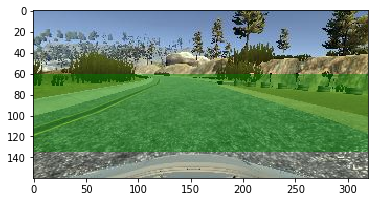

In [4]:
# Plot sample image
sample_image_name = driving_df.loc[152]['Center image']  # randomly chosen index
sample_image_file = os.path.join(data_dir, sample_image_name)
sample_image = cv2.imread(sample_image_file)

plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

# Determine region of interest for cropping
original_image_height = sample_image.shape[0]
original_image_width = sample_image.shape[1]

# do not touch width
left = 0
right = original_image_width
# only crop height
bottom_crop = 25
top_crop = 60

bottom = original_image_height - bottom_crop
top = top_crop

rect = np.array([
    [left, top],
    [right, top],
    [right, bottom],
    [left, bottom]
])
rect_x = rect[:,0]-.5  # substract small amount to prevent plot from expanding into whitespace
rect_y = rect[:,1]

# Plot region of interest on top of sample image
plt.fill(rect_x, rect_y, facecolor='green', alpha=.5)

### Create train and validation sets from driving data

In [5]:
# Create training and validation dataset
train_set, validation_set = train_test_split(driving_df.values, test_size=0.2)

train_generator = steering_image_batch_generator(data_dir, train_set)
validation_generator = steering_image_batch_generator(data_dir, validation_set)

# Also create a smaller training and validation dataset for testing models
small_train_set, small_validation_set = train_test_split(driving_df[:1000].values, test_size=0.3)

images, steering = [], []
for row in small_train_set:
    i, s = parse_data_row(data_dir, row)
    images.append(i)
    steering.append(s)
x_train, y_train = np.array(images), np.array(steering)

images, steering = [], []
for row in small_validation_set:
    i, s = parse_data_row(data_dir, row)
    images.append(i)
    steering.append(s)
x_validation, y_validation = np.array(images), np.array(steering)

## PilotNet model

In [6]:
img_height = 160
img_width = 320

input_layer = Input(shape=(img_height, img_width, 3), name='input_image')

# Crop the input image first,
# then normalize it.
x = Cropping2D(cropping=((top_crop, bottom_crop), (0, 0)), name='image_cropping')(input_layer)
x = Lambda(lambda n: n / 255.0 - 0.5, name='image_normalization')(x)

x = Conv2D(24, (5, 5), strides=(2, 2), activation='relu', name='conv1')(x)
x = Conv2D(36, (5, 5), strides=(2, 2), activation='relu', name='conv2')(x)
x = Conv2D(48, (5, 5), strides=(2, 2), activation='relu', name='conv3')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv4')(x)
x = Conv2D(64, (3, 3), activation='relu', name='conv5')(x)
x = Flatten(name='flatten')(x)
x = Dense(100, name='dense1')(x)
x = Dense(50, name='dense2')(x)
x = Dense(10, name='dense3')(x)
x = Dense(1, name='output_angle')(x)

model = Model(input=input_layer, output=x)
model.compile(loss='mse', optimizer='Nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 160, 320, 3)       0         
_________________________________________________________________
image_cropping (Cropping2D)  (None, 75, 320, 3)        0         
_________________________________________________________________
image_normalization (Lambda) (None, 75, 320, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 77, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 37, 48)         43248     
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 35, 64)         27712     
__________

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ou...)`


In [7]:
import time

def get_log_dir(base_path='./logs/PilotNet', path_suffix=None):
    localtime = time.localtime()
    datetime_string = time.strftime("%Y-%m-%d_%H-%M-%S", localtime)
    if path_suffix is not None:
        return f'{base_path}/{path_suffix}/{datetime_string}'
    return f'{base_path}/{datetime_string}'

In [8]:
tensorboard = TensorBoard(log_dir=get_log_dir(path_suffix='/debug'),
                          batch_size=32,
                          write_images=True,
                          write_graph=True,
                          write_grads=True,
                          histogram_freq=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          batch_size=32,
          epochs=10,
          callbacks=[tensorboard, early])

Train on 700 samples, validate on 300 samples
Epoch 1/10
700/700 [==============================] - 3s 5ms/step - loss: 3.3650 - val_loss: 0.0031
Epoch 2/10
700/700 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 3/10
700/700 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 4/10
700/700 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 5/10
700/700 [==============================] - 1s 1ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/10
700/700 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 00006: early stopping


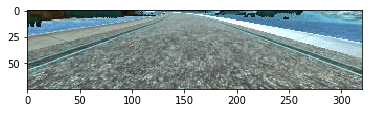

In [9]:
layer_name = 'image_cropping'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_train[None, 0])
plt.imshow(intermediate_output[0].astype(np.uint8))

In [ ]:
tensorboard = TensorBoard(log_dir=get_log_dir(),
                                  batch_size=self.batch_size,
                                  write_graph=False)
# Save the model according to the conditions
checkpoint = ModelCheckpoint('PilotNet.h5', monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=10,
                    steps_per_epoch=num_train_samples,
                    validation_steps=num_validation_samples,
                    callbacks=[tensorboard, checkpoint, early])

## Xception - transfer learning model

In [ ]:
from keras.applications import Xception
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

img_width = 150
img_height = 150

model = Xception(weights='imagenet',
                 include_top=False,
                 input_shape=(img_height, img_width, 3))

# Freeze all layers of pre-trained model
for layer in model.layers:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1)(x)  # Regression output layer

model_final = Model(input=model.input, output=x)
model_final.compile(loss='mse', optimizer='Nadam')

# Save the model according to the conditions  
checkpoint = ModelCheckpoint('Xception_steering.h5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

model_final.fit_generator(train_generator, 
                          samples_per_epoch=len(train_samples), 
                          validation_data=validation_generator,
                          nb_val_samples=len(validation_samples), 
                          nb_epoch=10, 
                          callbacks=[checkpoint, early])